# **Problem Statement**
#### The objective of this report is to optimize a model that can best predict the risk of diabetes progression. This will be used as a screening tool to help physicians with identifying patients at risk.

# **Getting Data**

In [2]:
from sklearn import datasets
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [3]:
diabetes= datasets.load_diabetes( return_X_y = False, as_frame=True, scaled=False)
df = pd.DataFrame(data= np.c_[diabetes['data'], diabetes['target']],
                     columns= diabetes['feature_names'] + ['target'])

# **Exploratory Data Analysis**

## Explore Data

In [4]:
# Review information like names of columns, data type and total records
df_info = df.info()
print(df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
None


In [5]:
# Review thr top 5 records of the data frame
df_head = df.head()
print(df_head)

    age  sex   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0  2.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0  1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0  2.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0
3  24.0  1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0   206.0
4  50.0  1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0   135.0


In [6]:
# Check if there are any null values in dataset
df_is_null = df.isnull().sum()
print(df_is_null)

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


## Explore Statistics

In [7]:
df_stats = df.describe()
print(df_stats)

              age         sex         bmi          bp          s1          s2   
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000  \
mean    48.518100    1.468326   26.375792   94.647014  189.140271  115.439140   
std     13.109028    0.499561    4.418122   13.831283   34.608052   30.413081   
min     19.000000    1.000000   18.000000   62.000000   97.000000   41.600000   
25%     38.250000    1.000000   23.200000   84.000000  164.250000   96.050000   
50%     50.000000    1.000000   25.700000   93.000000  186.000000  113.000000   
75%     59.000000    2.000000   29.275000  105.000000  209.750000  134.500000   
max     79.000000    2.000000   42.200000  133.000000  301.000000  242.400000   

               s3          s4          s5          s6      target  
count  442.000000  442.000000  442.000000  442.000000  442.000000  
mean    49.788462    4.070249    4.641411   91.260181  152.133484  
std     12.934202    1.290450    0.522391   11.496335   77.093005 

## Visualization

### Box Plot

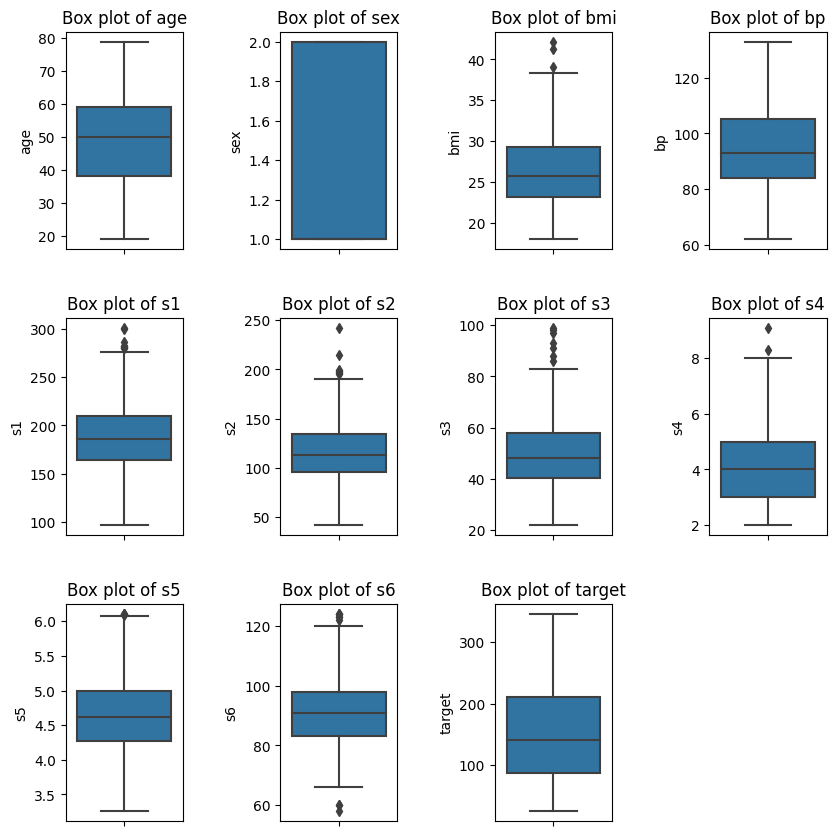

In [8]:
num_cols = len(df.columns)
n_cols = int(np.ceil(np.sqrt(num_cols)))
n_rows = int(np.ceil(num_cols / n_cols))
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(9, 9))
axs = axs.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col], ax=axs[i])
    axs[i].set_title(f'Box plot of {col}')


# Remove the unused subplots
for i in range(num_cols, len(axs)):
    fig.delaxes(axs[i])

fig.tight_layout(pad=3.0)
plt.show()

### Histograms

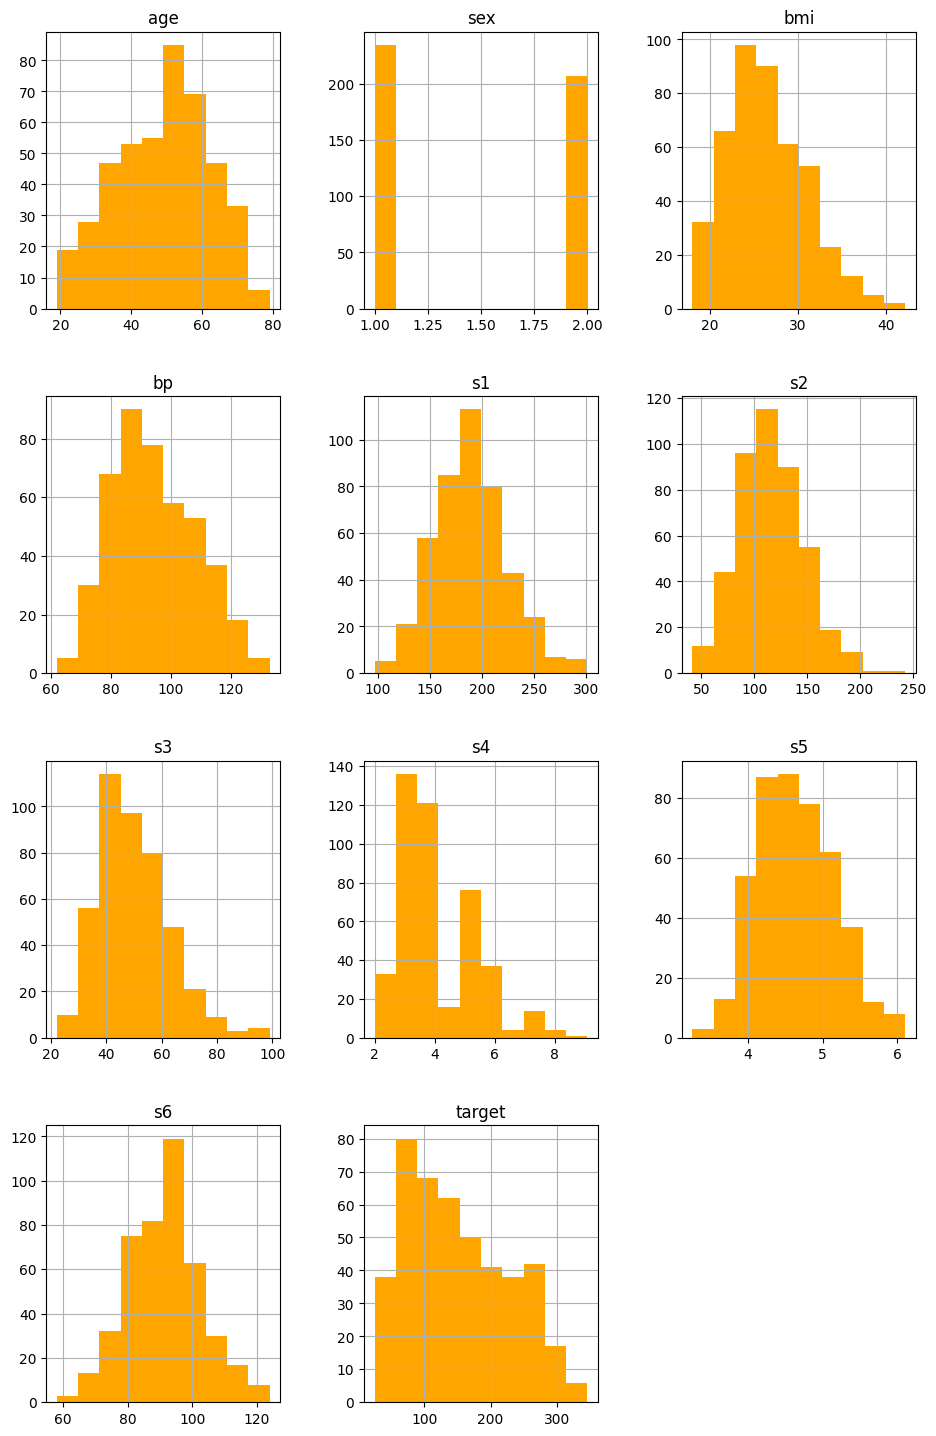

In [9]:
df.hist(figsize=(10, 15) , bins = 10 , color='orange') 
plt.tight_layout(pad=3.0)  
plt.show()

Observations :

 - BMI peaks around 26 so looks like higher no. of individuals in the dataset falls in the overweight category.
 - Dataset includes a different range of ages, with most individuals being around middle age.
 - Distribution of all other health-related variables appears to be normal

### Correlation Matrix 

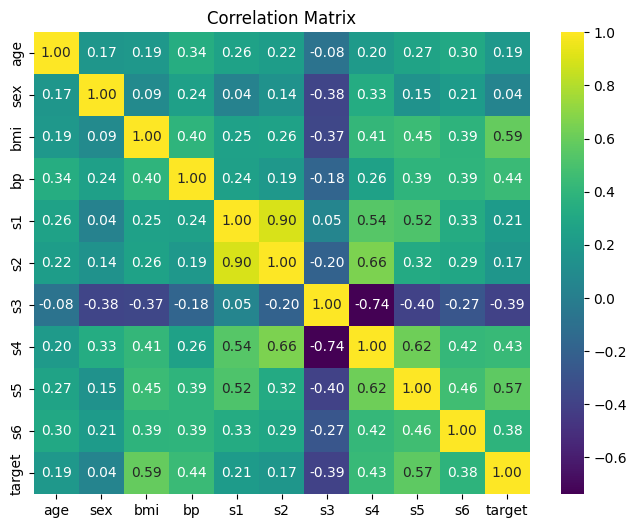

In [10]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Observations: 

- Strong positive correlation of .59 observed between BMI and the target variable . This suggests that as the BMI increases, the target variable will increase as well.

- Very Strong positive correlation of 0.90 between S1 and S2 . 

- Strong negative correlation of -0.74 between S3 and S4.

# **Data Cleaning** 

###  Observations based on EDA:

### - There are no missing values in the dataset as all features have a count of 442.
### - The minimum and maximum values of the features do not indicate any outliers.

### From the above observations , it seems that the data is clean and does not require any additional cleaning.

# **Feature Selection** 

### Removal of Multicollinearity in the Dataset: ###

Since there is a very strong correlation between S1 and S2 and that they might carry similar information, including them both could lead to multicollinearity. Similar is the case with S3 and S4. So we are selecting all features except S2 and S4 since they show certain levels of correlation with target variable.

In [11]:
X = df.drop(['s2', 's4', 'target'], axis=1)
y = df[["target"]]
print(X)

      age  sex   bmi      bp     s1    s3      s5     s6
0    59.0  2.0  32.1  101.00  157.0  38.0  4.8598   87.0
1    48.0  1.0  21.6   87.00  183.0  70.0  3.8918   69.0
2    72.0  2.0  30.5   93.00  156.0  41.0  4.6728   85.0
3    24.0  1.0  25.3   84.00  198.0  40.0  4.8903   89.0
4    50.0  1.0  23.0  101.00  192.0  52.0  4.2905   80.0
..    ...  ...   ...     ...    ...   ...     ...    ...
437  60.0  2.0  28.2  112.00  185.0  42.0  4.9836   93.0
438  47.0  2.0  24.9   75.00  225.0  42.0  4.4427  102.0
439  60.0  2.0  24.9   99.67  162.0  43.0  4.1271   95.0
440  36.0  1.0  30.0   95.00  201.0  42.0  5.1299   85.0
441  36.0  1.0  19.6   71.00  250.0  97.0  4.5951   92.0

[442 rows x 8 columns]


# **Data Split to Train, Test and Validation** 

In [12]:
train_ratio = .70
test_ratio = .30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42) 


# **Polynomial Regression**

In [13]:
degrees = [1,2]
cv_results = []
for degree in degrees:
    polynomial_model = Pipeline([('polynomial',PolynomialFeatures(degree=degree)), ('linear', LinearRegression())])
    # Use cross-validation to compute the mean score across multiple splits of the data
    results = cross_validate(polynomial_model, X_train, y_train, cv=5, scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

    cv_results.append({
            'Model': f'Polynomial Model Degree {degree}',
            'R-Squared Mean': np.mean(results['test_r2']),
            'R-Squared Std': np.std(results['test_r2']),
            'MAE Mean': -np.mean(results['test_neg_mean_absolute_error']),
            'MAE Std': np.std(results['test_neg_mean_absolute_error']),
            'MAPE Mean': np.mean(results['test_neg_mean_absolute_percentage_error']),
            'MAPE Std': np.std(results['test_neg_mean_absolute_percentage_error'])
        })

print(cv_results)



[{'Model': 'Polynomial Model Degree 1', 'R-Squared Mean': 0.4498016668837511, 'R-Squared Std': 0.11790864892008822, 'MAE Mean': 45.878216897680616, 'MAE Std': 1.3002721785307143, 'MAPE Mean': -0.41055966158470786, 'MAPE Std': 0.05002537784745475}, {'Model': 'Polynomial Model Degree 2', 'R-Squared Mean': 0.2557104658001257, 'R-Squared Std': 0.20843816104993432, 'MAE Mean': 51.84029072678305, 'MAE Std': 5.9197723194174285, 'MAPE Mean': -0.4500122343679259, 'MAPE Std': 0.08042026406619}]


# **Decision Tree**

In [14]:
max_depths = [1,2]
cv_results_decision_tree = []
for max_depth in max_depths :
    decisiontree_model = tree.DecisionTreeRegressor(max_depth=max_depth)
    results = cross_validate(decisiontree_model, X_train, y_train, cv=5, scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

    cv_results.append({
            'Model': f'Decision Tree depth {max_depth}',
            'R-Squared Mean': np.mean(results['test_r2']),
            'R-Squared Std': np.std(results['test_r2']),
            'MAE Mean': -np.mean(results['test_neg_mean_absolute_error']),
            'MAE Std': np.std(results['test_neg_mean_absolute_error']),
            'MAPE Mean': np.mean(results['test_neg_mean_absolute_percentage_error']),
            'MAPE Std': np.std(results['test_neg_mean_absolute_percentage_error'])
        })
    
print(cv_results)

[{'Model': 'Polynomial Model Degree 1', 'R-Squared Mean': 0.4498016668837511, 'R-Squared Std': 0.11790864892008822, 'MAE Mean': 45.878216897680616, 'MAE Std': 1.3002721785307143, 'MAPE Mean': -0.41055966158470786, 'MAPE Std': 0.05002537784745475}, {'Model': 'Polynomial Model Degree 2', 'R-Squared Mean': 0.2557104658001257, 'R-Squared Std': 0.20843816104993432, 'MAE Mean': 51.84029072678305, 'MAE Std': 5.9197723194174285, 'MAPE Mean': -0.4500122343679259, 'MAPE Std': 0.08042026406619}, {'Model': 'Decision Tree depth 1', 'R-Squared Mean': 0.21641512948512362, 'R-Squared Std': 0.1139327258022049, 'MAE Mean': 56.911326928848915, 'MAE Std': 2.108040110266646, 'MAPE Mean': -0.5136280613716349, 'MAPE Std': 0.04128530957776461}, {'Model': 'Decision Tree depth 2', 'R-Squared Mean': 0.2878446837293966, 'R-Squared Std': 0.20355480523060893, 'MAE Mean': 52.446356355236524, 'MAE Std': 4.427388251358452, 'MAPE Mean': -0.45876703464839236, 'MAPE Std': 0.04420540628839849}]


# **KNN**

In [15]:
n_neighbors = [3,5]
cv_results_knn = []
for n_neighbor in n_neighbors :
    knn_model = neighbors.KNeighborsRegressor(n_neighbors=n_neighbor)
    results = cross_validate(knn_model, X_train, y_train, cv=5, scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

    cv_results.append({
            'Model': f'kNN n={n_neighbor}',
            'R-Squared Mean': np.mean(results['test_r2']),
            'R-Squared Std': np.std(results['test_r2']),
            'MAE Mean': -np.mean(results['test_neg_mean_absolute_error']),
            'MAE Std': np.std(results['test_neg_mean_absolute_error']),
            'MAPE Mean': np.mean(results['test_neg_mean_absolute_percentage_error']),
            'MAPE Std': np.std(results['test_neg_mean_absolute_percentage_error'])
        })
    
print(cv_results)

[{'Model': 'Polynomial Model Degree 1', 'R-Squared Mean': 0.4498016668837511, 'R-Squared Std': 0.11790864892008822, 'MAE Mean': 45.878216897680616, 'MAE Std': 1.3002721785307143, 'MAPE Mean': -0.41055966158470786, 'MAPE Std': 0.05002537784745475}, {'Model': 'Polynomial Model Degree 2', 'R-Squared Mean': 0.2557104658001257, 'R-Squared Std': 0.20843816104993432, 'MAE Mean': 51.84029072678305, 'MAE Std': 5.9197723194174285, 'MAPE Mean': -0.4500122343679259, 'MAPE Std': 0.08042026406619}, {'Model': 'Decision Tree depth 1', 'R-Squared Mean': 0.21641512948512362, 'R-Squared Std': 0.1139327258022049, 'MAE Mean': 56.911326928848915, 'MAE Std': 2.108040110266646, 'MAPE Mean': -0.5136280613716349, 'MAPE Std': 0.04128530957776461}, {'Model': 'Decision Tree depth 2', 'R-Squared Mean': 0.2878446837293966, 'R-Squared Std': 0.20355480523060893, 'MAE Mean': 52.446356355236524, 'MAE Std': 4.427388251358452, 'MAPE Mean': -0.45876703464839236, 'MAPE Std': 0.04420540628839849}, {'Model': 'kNN n=3', 'R-Squ

# **Cross-Validation Summary**

In [20]:
cross_validation_summary = f"""| Model | R-Squared Mean | R-Squared Std | MAE Mean | MAE Std | MAPE Mean | MAPE Std |
|\n|-------|----------------|---------------|----------|---------|-----------|----------|\n"""
for result in cv_results:
    cross_validation_summary += "| {Model} | {R-Squared Mean} | {R-Squared Std} | {MAE Mean} | {MAE Std} | {MAPE Mean} | {MAPE Std} |\n".format(**result)
    
print(cross_validation_summary)

| Model | R-Squared Mean | R-Squared Std | MAE Mean | MAE Std | MAPE Mean | MAPE Std |
|
|-------|----------------|---------------|----------|---------|-----------|----------|
| Polynomial Model Degree 1 | 0.4498016668837511 | 0.11790864892008822 | 45.878216897680616 | 1.3002721785307143 | -0.41055966158470786 | 0.05002537784745475 |
| Polynomial Model Degree 2 | 0.2557104658001257 | 0.20843816104993432 | 51.84029072678305 | 5.9197723194174285 | -0.4500122343679259 | 0.08042026406619 |
| Decision Tree depth 1 | 0.21641512948512362 | 0.1139327258022049 | 56.911326928848915 | 2.108040110266646 | -0.5136280613716349 | 0.04128530957776461 |
| Decision Tree depth 2 | 0.2878446837293966 | 0.20355480523060893 | 52.446356355236524 | 4.427388251358452 | -0.45876703464839236 | 0.04420540628839849 |
| kNN n=3 | 0.09518420596694654 | 0.0705787333613553 | 59.332628239026974 | 4.23217283546885 | -0.5143326861680219 | 0.05898222361850602 |
| kNN n=5 | 0.15667406040959556 | 0.05960476866791364 | 57.83

Based on the results obtained from Cross Validation, the Polynomial Model Degree 1 looks to be the best model. 

Reasons : 
It has the highest R-Squared Mean value of 0.4498016668837511, which indicates that this model explains the most variance in the target variable compared to the other models.
Mean Absolute Error (MAE) is lowest among all models.
The Mean Absolute Percentage Error (MAPE) for this model is lowest among all other models.

# **Identify the best model**

In [17]:
polynomial_model_chosen = Pipeline([('polynomial',PolynomialFeatures(degree=1)), ('linear', LinearRegression())])
polynomial_model_chosen.fit(X = X_train, y = y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=1)),
                ('linear', LinearRegression())])

## Run the chosen model on the test set

In [18]:
y_test_predict = polynomial_model_chosen.predict(X_test)

r2 = r2_score(y_test, y_test_predict)
mae = mean_absolute_error(y_test, y_test_predict)
mape = mean_absolute_percentage_error(y_test,y_test_predict)
print(f"Degree: {1}, R-squared: {r2}, MAE: {mae}, MAPE: {mape}")
print(f'Model: {polynomial_model_chosen}')
print(f'Coefficients: {polynomial_model_chosen[-1].coef_[0][1:]}')
print(f'Intercept: {polynomial_model_chosen[-1].intercept_[0]}')

Degree: 1, R-squared: 0.48165667224395015, MAE: 41.995816092260725, MAPE: 0.36608768174343176
Model: Pipeline(steps=[('polynomial', PolynomialFeatures(degree=1)),
                ('linear', LinearRegression())])
Coefficients: [  0.11649957 -23.35278823   6.08309134   1.28013172  -0.2136582
  -1.10955105  39.15705592   0.22675154]
Intercept: -208.810569665184


## Plot the chosen model on the train and test set

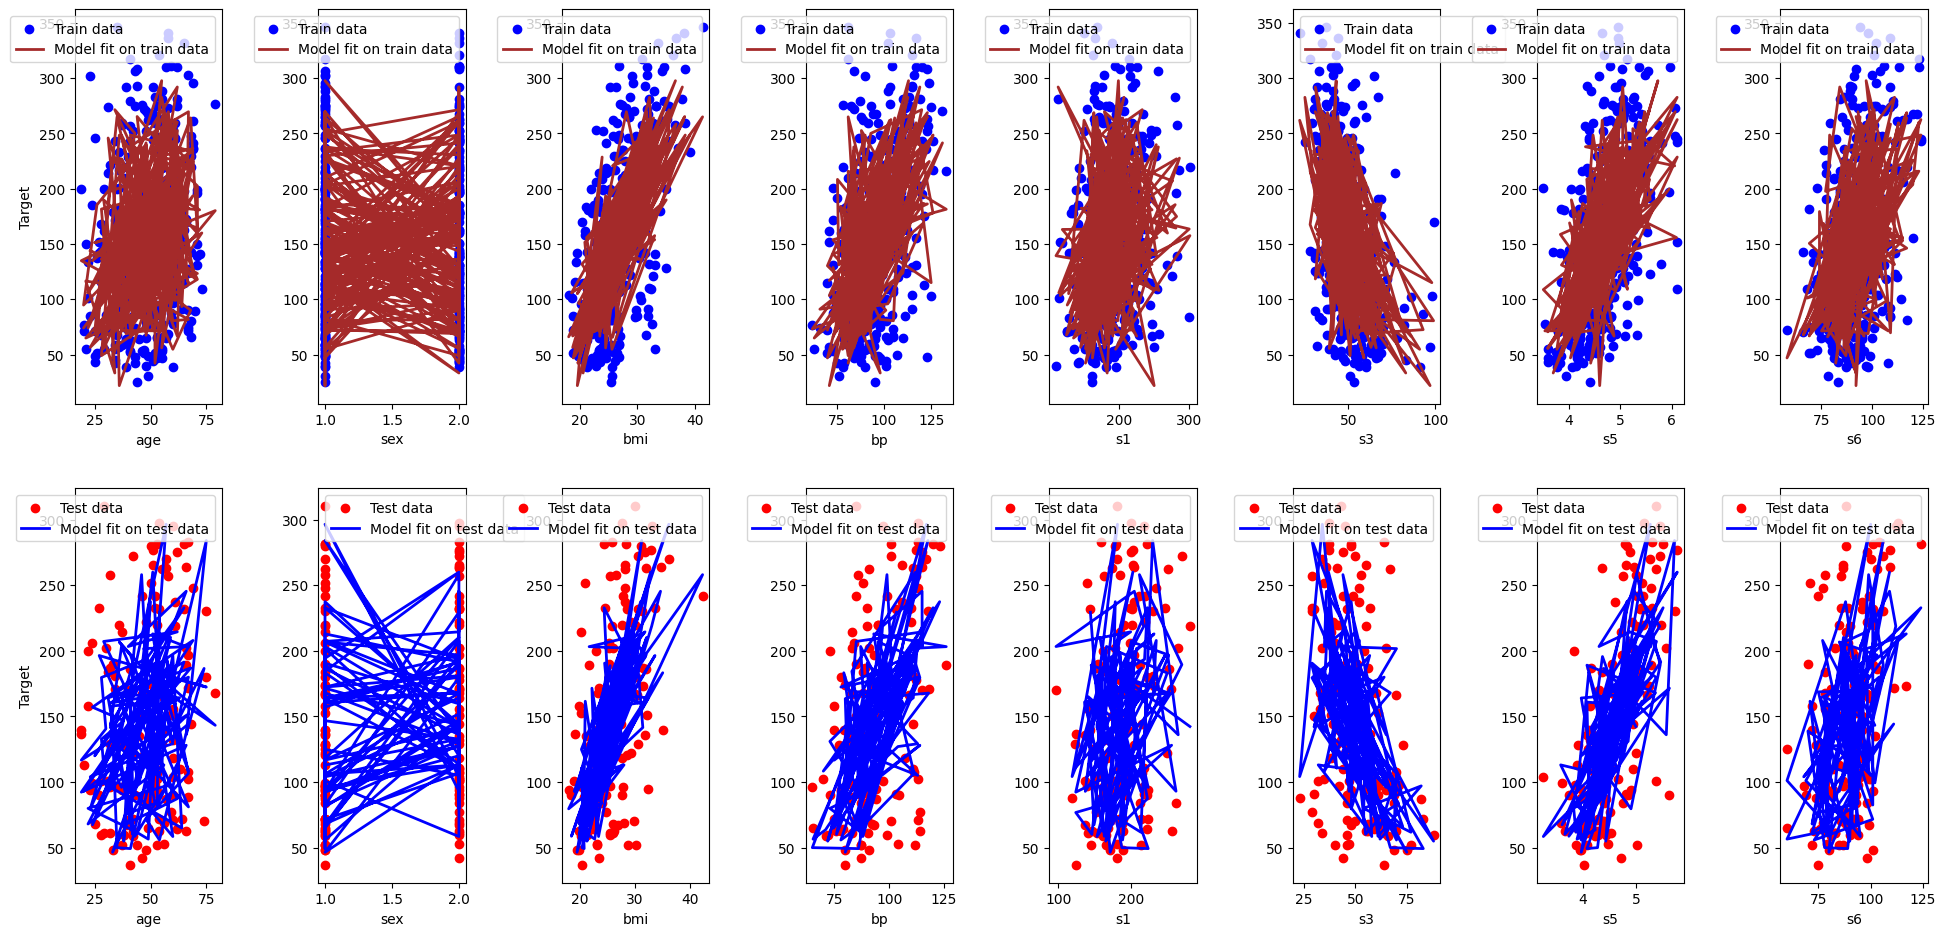

In [19]:
# Create subplots
fig, axs = plt.subplots(2, 8, figsize=(20, 10))

# Predict outputs for train set
y_train_predict = polynomial_model_chosen.predict(X_train)


num_features = 8
feature_names = ['age', 'sex',   'bmi',      'bp',     's1',    's3',      's5',     's6']


for i in range(num_features):
    # Plot the the model fit for train set
    axs[0, i].scatter(X_train.iloc[:, i], y_train, color='blue', label='Train data')
    axs[0, i].plot(X_train.iloc[:, i], y_train_predict, color='brown', linewidth=2, label='Model fit on train data')
    axs[0, i].legend()
    axs[0, i].set_xlabel(feature_names[i])
    
    # Plot the the model fit for test set
    axs[1, i].scatter(X_test.iloc[:, i], y_test, color='red', label='Test data')
    axs[1, i].plot(X_test.iloc[:, i], y_test_predict, color='blue', linewidth=2, label='Model fit on test data')
    axs[1, i].legend()
    axs[1, i].set_xlabel(feature_names[i])

    # Add labels for Output
    if i == 0:
        axs[0, i].set_ylabel('Target')
        axs[1, i].set_ylabel('Target')

# Display the plots
plt.tight_layout(pad=3.0)
plt.show()

# Conclusion

The model that performed the best was the Polynomial Model of degree 1. It had an R-squared value of 0.4816 on the test set, which means it could explain about 48.16% of the variance in the target variable. The model had an average error (MAE) of 41.99 and an average percentage error (MAPE) of 0.37.

### Model Limitations and Failures

The Polynomial Model Degree 1 shows a mixed performance on the test set compared to the training set. The R-squared and MAE values have improved, indicating better fit but the MAPE value has increased which indicates higher percentage errors in prediction. This could be due to overfitting on the training set or due to the presence of outliers.
